In [1]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 

# Bonus vector manipulation
import pandas as pd
import geopandas as gpd
from shapely import wkt
from datetime import datetime

CMAP = "Blues"

# Land Change

This notebook uses changes in Fractional Cover to identify land change. The algorithm identifies a "baseline" and "analysis" time period and then compares the spectral parameters in each of those time periods. Significant reductions in vegetation are coincident with land change. In some cases these changes could be deforestation. Users of this algorithm should not accept the accuracy of the results but should conduct ground validation testing to assess accuracy. In most cases, these algorithms can be used to identify clusters of pixels that have experienced change and allow targeted investigation of those areas by local or regional governments.

In [2]:
# Load Data Cube Configuration
import datacube
dc = datacube.Datacube(app = 'land_degredation')#, config = '/home/localuser/.datacube.conf')

# Import Data Cube API
import utils_dcal.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()#config = '/home/localuser/.datacube.conf')
dc = api.dc

from utils_dcal.data_cube_utilities.dc_display_map import display_map
from sac_utils.createAOI import create_lat_lon
from sac_utils.createindices import NDVI, EVI
from sac_utils.clean_mask import landsat_qa_clean_mask
from sac_utils.dc_mosaic import create_max_ndvi_mosaic, create_min_ndvi_mosaic, create_median_mosaic, create_mosaic, create_hdmedians_multiple_band_mosaic
#from utils_dcal.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_min_ndvi_mosaic, create_median_mosaic, create_mosaic, create_hdmedians_multiple_band_mosaic
from deaAfricascripts.deafrica_plotting import rgb
from utils_dcal.data_cube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
import matplotlib.pyplot as plt
from matplotlib.cm import RdYlGn, Greens
from sac_utils.fromDCALscripts import threshold_plot


In [3]:
RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

## Set Variables

In [4]:
#inputs
#options "LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4" and "SENTINEL_2"
platform_base = "LANDSAT_8"
platform_analysis = "LANDSAT_8"
#For Fiji this should be the only option - may change for Solomon and Vanuatu
output_projection = "EPSG:32760"
res = (30)


# Select the start and end periods for your analysis products
# The datetime function is (Year,Month,Day)
# These time windows will be used to make a mosaic, so typically pick a year length or more
# Be sure to evaluate the RGB mosaics to affirm they are not full of clouds

#set baseline start and end of period
baseline_start_date = '2015-3-1'
baseline_end_date = '2015-5-1'

#set the analysis start and end of period
analysis_start_date = '2016-3-1'
analysis_end_date = '2016-5-1'

# Select the cloud-free mosaic type
# Options are: max_ndvi, min_ndvi, median, most_recent_pixel, geomedian
# If a geomedian is selected, it will take much longer to process
# It is most common to use the max_ndvi or median for these land change analyses
# HINT: Consider max_ndvi mosaics for NDVI analyses and median mosaics for EVI analyses 
mosaic_type = "median" # change this to geomedian 

#define AOI
#central area - do dates 2013- 2014 and 2018-2019
#aoi_wkt = "POLYGON ((177.42576599121094 -18.058395415674948, 177.5390625 -18.058395415674948, 177.5390625 -17.96567026450931, 177.42576599121094 -17.96567026450931, 177.42576599121094 -18.058395415674948))"
# wakaya island - hit by cyclone winston in feb 2016  - dates end of JAn 2015-2016, start of March 2016 - 2017
aoi_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"

## create AOI

In [5]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [6]:
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = lat_extents, longitude = lon_extents)

## Translate inputs and load data

In [7]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
water_measurements = ["water_classification"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        product = 's2_esa_sr_granule'
        measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
        ###CHANGE WHEN S2 WOFS READY
        water_product = 'SENTINEL_2_PRODUCT DEFS'
    elif platform in ["LANDSAT_8"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls8_usgs_sr_scene'
        water_product = 'ls8_water_classification'
    elif platform in ["LANDSAT_7"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls7_usgs_sr_scene'
        water_product = 'ls7_water_classification'
    elif platform in ["LANDSAT_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls5_usgs_sr_scene'
        water_product = 'ls5_water_classification'
    elif platform in ["LANDSAT_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls4_usgs_sr_scene'
        water_product = 'ls4_water_classification'
    else:
        print("invalid platform")
    return product, measurements, water_product

In [8]:
baseline_product, baseline_measurement, baseline_water_product = create_product_measurement(platform_base)
analysis_product, analysis_measurement, analysis_water_product = create_product_measurement(platform_analysis)

In [9]:
#create resolution
resolution = (-res, res)

In [10]:
#format dates
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period

baseline_time_period = createDate(baseline_start_date, baseline_end_date)
analysis_time_period = createDate(analysis_start_date, analysis_end_date)

print(baseline_time_period)

(datetime.date(2015, 3, 1), datetime.date(2015, 5, 1))


In [11]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes 
query = {
    'y': lat_extents,
    'x': lon_extents,
    'output_crs': output_projection,  
    'resolution': resolution
}

In [12]:
baseline_ds = dc.load(
    time = baseline_time_period,
    measurements = baseline_measurement,
    product = baseline_product,
    platform = platform_base,
    **query
)


In [13]:
analysis_ds = dc.load(
    time = analysis_time_period,
    measurements = analysis_measurement,
    product = analysis_product,
    platform = platform_analysis,                         
    **query
)

> #### Check if loads are valid

In [14]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [15]:
if is_dataset_empty(baseline_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

In [16]:
if is_dataset_empty(analysis_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Analysis Dataset!")

> #### Clean Data
> Generating boolean masks that highlight valid pixels
> Pixels must be cloud-free over land or water to be considered

In [17]:
#create cloud mask
baseline_clean_mask = landsat_qa_clean_mask(baseline_ds, platform_base)
analysis_clean_mask = landsat_qa_clean_mask(analysis_ds, platform_analysis)

In [18]:
#mask products
baseline_ds = baseline_ds.where(baseline_clean_mask)
analysis_ds = analysis_ds.where(analysis_clean_mask)

>#### Mosaic
> Use clean masks in a time series composite

In [19]:
mosaic_function = {"median": create_median_mosaic,
                   "max_ndvi": create_max_ndvi_mosaic,
                   "min_ndvi": create_min_ndvi_mosaic,
                   "geomedian": create_hdmedians_multiple_band_mosaic,
                   "most_recent_pixel": create_mosaic}

In [20]:
new_compositor = mosaic_function[mosaic_type]

In [21]:
baseline_composite = new_compositor(baseline_ds, clean_mask = baseline_clean_mask.values, no_data=float('nan'))
analysis_composite = new_compositor(analysis_ds, clean_mask = analysis_clean_mask.values, no_data=float('nan'))

In [22]:
baseline_clean_masked = landsat_qa_clean_mask(baseline_composite, platform_base)
baseline_composite = baseline_composite.where(baseline_clean_masked)

In [23]:
analysis_clean_masked = landsat_qa_clean_mask(analysis_composite, platform_analysis)
analysis_composite = analysis_composite.where(analysis_clean_masked)

## Mask Water New

In [58]:
#when S2 mask is ready - can remove the if statement. 
if platform_base in ["LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:   
    water_scenes_base = dc.load(product=baseline_water_product,
            measurements = ["water_classification"],
            time = baseline_time_period,
            platform = platform_base, 
               **query)
    #change clouds to no data value
    water_classes_base = water_scenes_base.where(water_scenes_base >= 0)
elif platform_base in ["SENTINEL_2"]:
    water_classes_base = wofs_classify(baseline_ds, clean_mask=baseline_clean_mask.values , no_data = np.nan , x_coord='x', y_coord = "y")
    water_classes_base = water_classes.rename({'wofs': 'water_classification'})
               

In [59]:
#when S2 mask is ready - can remove the if statement. 
if platform_analysis in ["LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:   
    water_scenes_analysis = dc.load(product=analysis_water_product,
            measurements = ["water_classification"],
            time = analysis_time_period,
            platform = platform_analysis,  
               **query)
    #change clouds to no data value
    water_classes_analysis = water_scenes_analysis.where(water_scenes_analysis >= 0)
elif platform_analysis in ["SENTINEL_2"]:
    water_classes_analysis = wofs_classify(ds, clean_mask=analysis_clean_mask.values , no_data = np.nan , x_coord='x', y_coord = "y")
    water_classes_analysis = water_classes_analysis.rename({'wofs': 'water_classification'})
               

## mask water


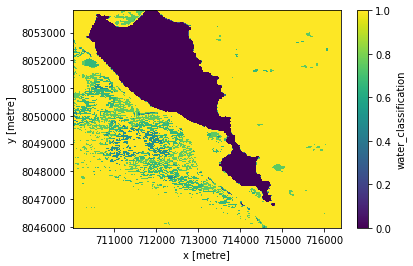

In [66]:
#create per scene water mask
from utils_dcal.data_cube_utilities.dc_water_classifier import wofs_classify
from utils_dcal.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_mean_mosaic, create_mosaic, create_median_mosaic
#water_classes_base = wofs_classify(baseline_ds, clean_mask=baseline_clean_mask.values , no_data = np.nan , x_coord='x', y_coord = "y")
#create mosiac of water mask
#change this to mean or median?
#water_composite_base = create_mean_mosaic(water_classes_base)
water_composite_base = water_classes_base.water_classification.mean(dim='time')
water_composite_mean_b= water_composite_base.compute()
water_composite_mean_b.plot()

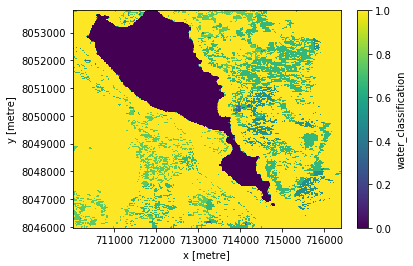

In [67]:
#water_classes_analysis = wofs_classify(analysis_ds, clean_mask=analysis_clean_mask.values , no_data = np.nan , x_coord='x', y_coord = "y")
#print(water_classes_analysis)
#water_classes_analysis2 = xr.Dataset.fillna(water_classes_analysis, -9999)
#create mosiac of water mask
#change this to mean or median?
#water_composite_analysis = create_mean_mosaic(water_classes_analysis2, no_data = -9999)
#water_composite_analysis.wofs.plot()
water_composite_analysis = water_classes_analysis.water_classification.mean(dim='time')
water_composite_mean_a = water_composite_analysis.compute()
water_composite_mean_a.plot()

(<Figure size 720x587.586 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff54fdb6d30>)

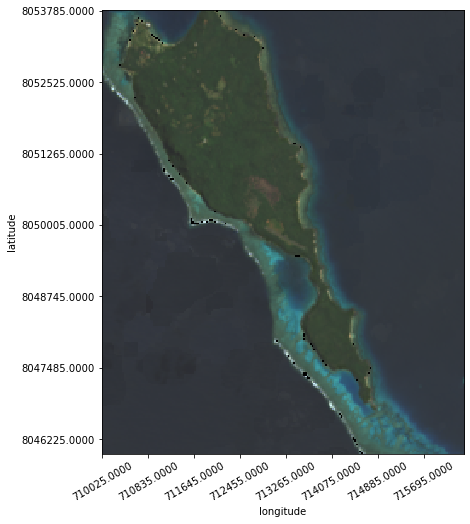

In [31]:
from utils_dcal.data_cube_utilities.dc_rgb import rgb
baseline_composite = baseline_composite.rename({"y": "latitude", "x":"longitude"})
analysis_composite = analysis_composite.rename({"y": "latitude", "x":"longitude"})
rgb(baseline_composite, use_data_min=True, use_data_max=True)

(<Figure size 720x587.586 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff54eb6cfd0>)

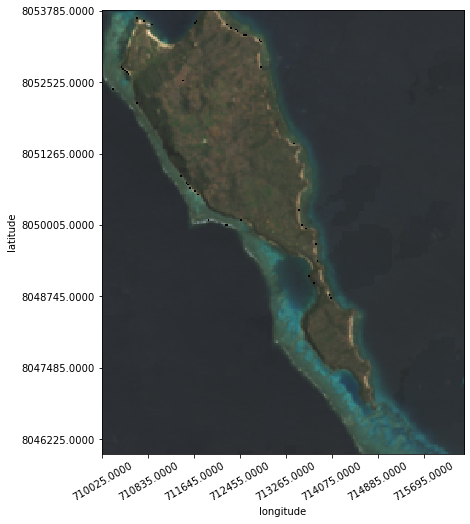

In [32]:
rgb(analysis_composite, use_data_min=True, use_data_max=True)

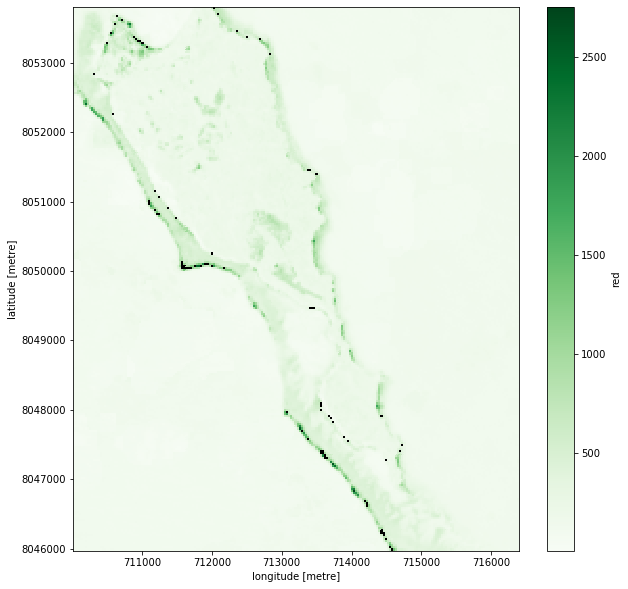

In [33]:
(baseline_composite.red).plot(figsize=(10,10),cmap = "Greens")

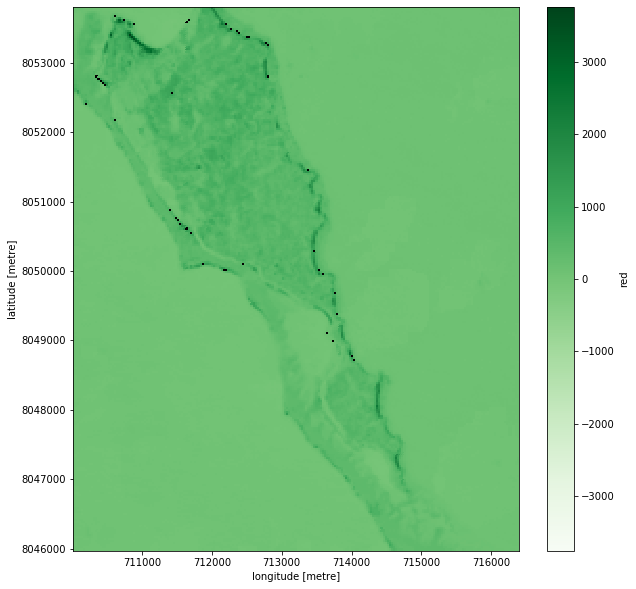

In [34]:
(analysis_composite.red).plot(figsize=(10,10),cmap = "Greens")

>## Plot a spectral index using the cloud-filtered mosaic

In [35]:
indices = 'FC'

if indices in ['FC']:
    print("indices chosen is FC")
else:
    print("indicies is invalid")

indices chosen is FC


In [36]:
print(baseline_clean_masked)

<xarray.DataArray (y: 261, x: 213)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * y        (y) float64 8.054e+06 8.054e+06 8.054e+06 ... 8.046e+06 8.046e+06
  * x        (x) float64 7.1e+05 7.101e+05 7.101e+05 ... 7.164e+05 7.164e+05


In [37]:

if indices in ['FC']:
    frac_classes = frac_coverage_classify(baseline_composite, clean_mask = baseline_clean_masked.values, no_data=0) 
else:
    print('indices not fractional cover')
    

In [38]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>

# Select a spectral index to plot by removing one of the comment tags (#) below
# Adjust the scale of the output using vmin and vmax

#(ndvi).plot(figsize=(10,10),cmap = "Greens", vmin=0.3, vmax=1.0)
#(evi).plot(figsize=(10,10),cmap = "Greens", vmin=1.75, vmax=2.5)
#(frac_classes.pv).plot(figsize=(10,10),cmap = "Greens", vmin=70.0, vmax=100.0)

In [39]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>>>

# Select a baseline threshold range for a given parameter ... which is basically a "mask"
# The analysis will only consider pixels in this range for change detection
# No data or cloud pixels will also be masked in this process

# If you want to see all change, you should select the full range of values for each parameter
# NDVI full range = 0.0 to 1.0
# EVI full range = 0.0 to 2.5
# Fractional Cover full range = 0.0 to 100.0

# If you want to mask out dense vegetation, typical of forested land, use the values below
# NDVI: 0.7 to 1.0
# EVI: 2.0 to 2.5



def determineThresholdRange(indices):
    '''Return the baseline_threshold_range based on indicies input.
    '''
    if indices in ['ndvi', 'NDVI']:
        baseline_threshold_range = (0.7, 1.0) 
        a = (NDVI(baseline_composite))
    elif indices in ['EVI', 'evi']:
        baseline_threshold_range = (2, 2.5)
        a = (EVI(baseline_composite))
    elif indices in ['FC']:
        baseline_threshold_range = (70, 100)
        a = frac_classes.pv
    else:
        print('indicies not valid')
    _min, _max = baseline_threshold_range
    baseline_filter_mask = np.logical_and(a > _min, a < _max) 
    return baseline_filter_mask 

In [68]:
#baseline_filter_mask = determineThresholdRange(indices)


In [69]:

RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

In [70]:
# This is the baseline threshold plot that shows GREEN pixels in the threshold range
# Pixels with values outside the threshold range are white 

#plt.figure(figsize = aspect_ratio_helper(baseline_filter_mask)) 
#baseline_filter_mask.plot(cmap = "Greens")

In [71]:
#baseline_composite.red.plot(cmap = "Greens")

baseline_composite = baseline_composite.where(baseline_filter_mask)
baseline_composite.red.plot(cmap = "Greens")

#analysis_composite = analysis_composite.where(analysis_filter_mask)
analysis_composite.red.plot(cmap = "Greens")

# Spectral Parameter Anomaly

from utils_dcal.data_cube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
#from sac_utils.fractional_cover import frac_coverage_classify 
#odc-hub/utils_sac/.py

In [72]:
def createparametercomposite(indices, baseline, analysis):
    '''Return the baseline_threshold_range based on indicies input.
    '''
    if indices in ['ndvi']:
        parameter_baseline_composite = NDVI(baseline)
        parameter_analysis_composite = NDVI(analysis)
    elif indices in ['EVI', 'evi']:
        parameter_baseline_composite = EVI(baseline)
        parameter_analysis_composite = EVI(analysis)
    elif indices in ['FC']:
        parameter_baseline_composite = frac_coverage_classify(baseline, clean_mask = baseline_clean_masked.values, no_data=0) 
        parameter_analysis_composite = frac_coverage_classify(analysis, clean_mask = baseline_clean_masked.values, no_data=0)  
        #parameter_baseline_composite = parameter_baseline_composite.pv
        #parameter_analysis_composite = parameter_analysis_composite.pv
    return parameter_baseline_composite, parameter_analysis_composite

In [73]:
parameter_baseline_composite, parameter_analysis_composite = createparametercomposite(indices, baseline_composite, analysis_composite )

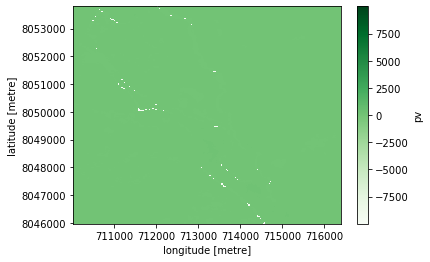

In [76]:
parameter_baseline_composite.pv.plot(cmap = "Greens")

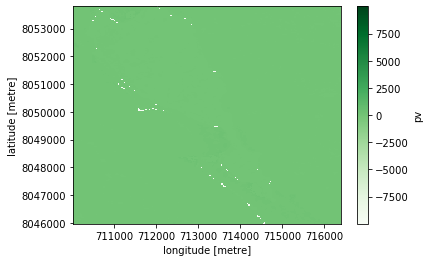

In [77]:
parameter_analysis_composite.pv.plot(cmap = "Greens")

## Apply water mask


In [90]:
frac_cov_baseline = parameter_baseline_composite.where(water_composite_mean_b.values <= 0.4).where(parameter_baseline_composite !=-9999)

<xarray.Dataset>
Dimensions:    (latitude: 261, longitude: 213)
Coordinates:
  * latitude   (latitude) float64 8.054e+06 8.054e+06 ... 8.046e+06 8.046e+06
  * longitude  (longitude) float64 7.1e+05 7.101e+05 ... 7.164e+05 7.164e+05
Data variables:
    bs         (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
    pv         (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
    npv        (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan


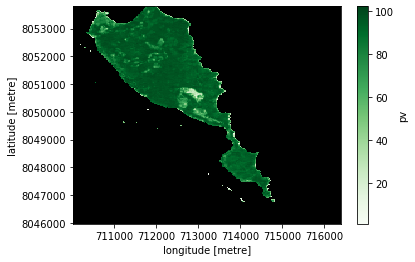

In [92]:
frac_cov_baseline.pv.plot(cmap = "Greens")

In [93]:
frac_cov_analysis = parameter_analysis_composite.where(water_composite_mean_b.values <= 0.4).where(parameter_analysis_composite !=-9999)

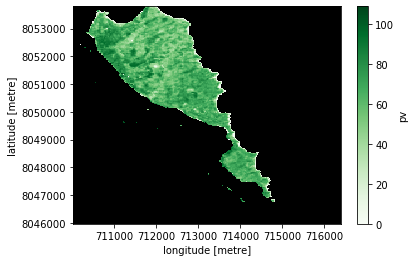

In [98]:
frac_cov_analysis.pv.plot(cmap = "Greens")

In [99]:
#parameter_anomaly = parameter_analysis_composite - parameter_baseline_composite
parameter_anomaly = frac_cov_analysis - frac_cov_baseline

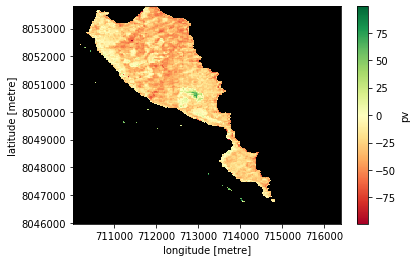

In [101]:
# Plot the parameter change from the baseline to the analysis period
# Significant loss in vegetation will be shown in RED
# Gains in vegetation will be shown in GREEN

#plt.figure(figsize = aspect_ratio_helper(parameter_anomaly)) 
parameter_anomaly.pv.plot(cmap = RdYlGn)

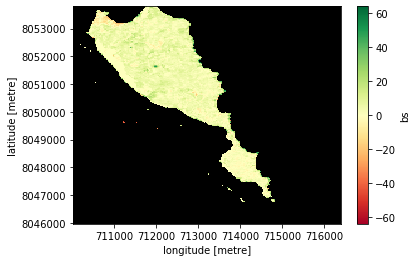

In [102]:
parameter_anomaly.bs.plot(cmap = RdYlGn)

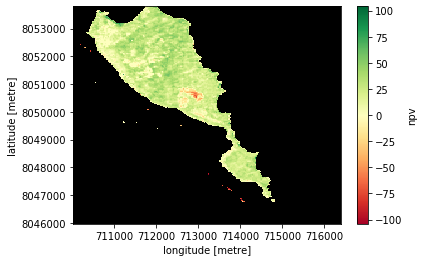

In [104]:
parameter_anomaly.npv.plot(cmap = RdYlGn)

# Anomaly Threshold Product

In [50]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>>>

# Select an Anomaly Threshold Range to filter the results from the previous image
# Be sure to put the smallest value in the "minimum_change" location (be careful of negative values)
# Losses are typically in these ranges for deforestation


In [51]:
def changeAnomalyRange(indices):
    '''Return the baseline_threshold_range based on indicies input.
    '''
    if indices in ['ndvi']:
        minC = -0.7
        maxC = -0.2
    elif indices in ['EVI', 'evi']:
        minC = -1.75
        maxC = -0.5
    elif indices in ['FC']:
        minC = -70
        maxC = -20
    return minC, maxC

In [52]:
# Create a threshold plot using the MIN and MAX range defined above
minimum_change, maximum_change = changeAnomalyRange(indices)

In [53]:
no_data_mask = np.logical_or(np.isnan(baseline_composite.red.values), np.isnan(analysis_composite.red.values))

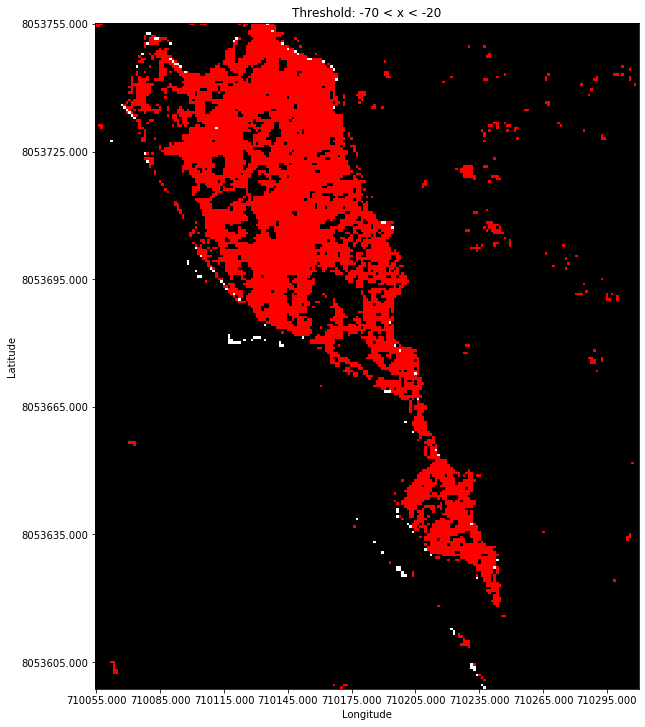

In [54]:
# Plot the parameter change using thresholds and 3 colors 
# RED = data in the threshold range (significant land change)
# BLACK = data outside the threshold range (no significant change)
# WHITE = data outside the baseline mask (not dense vegetation) or clouds (no data)
#parameter_anomaly = parameter_anomaly.rename({"x":"latitude", "y":"longitude"})
threshold_plot(parameter_anomaly, minimum_change, maximum_change, mask = no_data_mask, width  = 10)

In [55]:
from utils_dcal.data_cube_utilities.import_export import export_slice_to_geotiff

In [56]:
from utils_dcal.data_cube_utilities.dc_utilities import write_png_from_xr, write_geotiff_from_xr

In [57]:
# CHANGE HERE >>>>>>>>>>>>>

write_geotiff_from_xr('ndvi_test.tiff', parameter_anomaly, crs=output_crs)

NameError: name 'output_crs' is not defined